In [1]:
import pandas as pd
from helpers import config
import plotly.express as px
from helpers.preprocessing import *
from helpers import config
%load_ext autoreload
%autoreload 2

# Helper functions

In [2]:
def get_pair(df,m1,m2):
    return df[(df.market1==m1) * (df.market2==m2)]

def keep_positive(x):
    """return the data for which lags are positive ON AVERAGE"""
    to_keep = x[["lag","pair"]].groupby("pair").mean()>0#.set_index("pair")
    to_keep = to_keep.rename(columns={"lag":"lag+"})
    x = x.set_index("pair").join(to_keep,how="inner").reset_index()
    return x[x["lag+"]]

def remove_lag_outliers(df,confidence=0.98,replace=None):
    quantile = df["lag"].abs().quantile(q=confidence)
    if replace!=None:
        df[df.lag.abs() > quantile]["lag"] = replace
        return df
    return df[df.lag.abs() <= quantile]

def add_pair_names(df):
    df["pair"] = df["market1"]+"_"+df["market2"]
    return df

def absolute_lag(df):
    df["lag"] = df["lag"].abs()
    return df

def pipeline(df,transforms):
    for t in transforms:
        df = t(df)
    return df

def pair_wise_moving_average(df,rolling_window):
    """the moving average needs to be compute separately on each market pair"""
    res = df.copy().set_index("pair")
    pairs = res.index.unique()
    for pair in pairs:
        res.loc[pair,"lag"] = moving_average(res.loc[pair,"lag"],w=rolling_window)
    return res.reset_index() 

## Loading data

In [3]:
signal = "trade"
lags_ret = pd.read_csv(config["files"]["results"][signal]["all_best_lags"].format("_".join(["numeric","log_returns"])))
lags_price = pd.read_csv(config["files"]["results"][signal]["all_best_lags"].format("_".join(["numeric"])))

In [4]:
mean_returns = pd.read_csv(config["files"]["results"][signal]["mean_trade_returns"].format("_".join(["US",signal])))
mean_prices  = pd.read_csv(config["files"]["results"][signal]["mean_trade_prices"].format("_".join(["US",signal])))

In [5]:
def plot_mean_prices():
    fig = px.line(mean_prices, x="date", y="price",title=f"mean {signal} prices vs date",log_y=False)
    fig.show()
    
def plot_mean_prices():
    fig = px.line(mean_prices, x="date", y="price",title=f"mean {signal} prices vs date",log_y=False)
    fig.show()

# Plotting lags

In [6]:
def plot_pair_lags(df,m1,m2):
    fig = px.line(get_pair(best_lags,m1,m2), x="date", y="lag", title=f"lags vs date between {m1}/{m2}")
    fig.show()

def plot_all_pairs(df,rolling_window=1):
    
    to_plot = pipeline(df,[add_pair_names,keep_positive,remove_lag_outliers,absolute_lag])
    # rolling average
    to_plot = pair_wise_moving_average(to_plot,rolling_window)
    
    fig = px.line(to_plot, x="date", y="lag",color="pair", title=f"lags vs date (all pairs)",log_y=False)
    fig.show()

In [7]:
plot_all_pairs(lags_price,60)

In [78]:
plot_all_pairs(lags_ret,60)

https://www.24heures.ch/economie/benefice-net-shell-divise-huit-2015/story/29746011
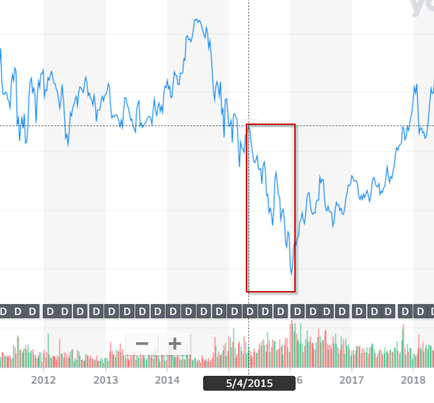

# Lags vs distance

## visualization

In [7]:
def get_distance(a,b):
    return config["distances"][a][b]

def plot_lag_vs_distance(lags_data,date1,date2):
    mean_lags = []
    distances = []
    for m1 in config["markets"]["list"]:
        for m2 in config["markets"]["list"]:
            if m1>m2:
                locality_data = get_pair(lags_data,m1,m2)
                locality_data = locality_data[(locality_data["date"]>=date1)*(locality_data["date"]<=date2)]
                mean_lag      = locality_data.lag.abs().mean()
                distance = get_distance(m1,m2)

                mean_lags.append(mean_lag)
                distances.append(distance)
    to_plot = pd.DataFrame({"distance": distances,"mean_lag":mean_lags})

    fig = px.scatter(to_plot, x=f"distance", y="mean_lag",trendline="ols") 
    fig.update_layout(
    title=f"mean lag vs distance ({date1} to {date2})",
    xaxis_title="distance(km)",
    yaxis_title="mean lag(ms)")  
    fig.show()

In [8]:
date1,date2 = "2006-00-01","2017-12-31"
plot_lag_vs_distance(lags_price,date1,date2)

In [9]:
date1,date2 = "2009-06-00","2009-08-00"
plot_lag_vs_distance(lags_price,date1,date2)

## rolling regression

In [10]:
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tools.tools import add_constant

In [11]:
def rolling_ols(lags_data,window=100):
    regression_data = pipeline(lags_data,[add_pair_names,keep_positive,absolute_lag])
    regression_data["distance"] = regression_data[["market1","market2"]].apply(lambda x : get_distance(x.market1,x.market2) ,axis=1)

    regression_data = remove_lag_outliers(regression_data,confidence=0.95)
    regression_data = regression_data.sort_values(["date","market1","market2"]).set_index("date")
    regression_data = add_constant(regression_data)
    
    mod = RollingOLS(regression_data["lag"], regression_data[["distance","const"]],
                     window=3*window) # we have 3 data points per day
    rolling_res = mod.fit()
    params = rolling_res.params.dropna().reset_index().rename(columns={"distance":"beta","const":"alpha"})

    fig = px.line(params, x="date", y="beta", title='evolution of beta parameter')
    fig.show()

In [12]:
rolling_ols(lags_ret,31)

C:\Users\kapps\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



# Lag vs Liquidity

In [79]:
# loading liquidity data
liquidity_data = pd.read_csv(config["files"]["results"][signal]["liquidity"])
liquidity_data.head(2)

date market     period
0  2005-07-25     GB   3.664000
1  2005-07-25     US  14.530999

In [80]:
def plot_liquidity(liquidity_data,rolling_window):
    to_plot = liquidity_data.copy()
    to_plot["period"] = moving_average(to_plot.period,w=rolling_window)
    fig = px.line(to_plot, x="date", y="period",color="market",title=f"daily median of elapsed period between trades vs date",log_y=False)
    fig.show()
    
plot_liquidity(liquidity_data,10)

In [29]:
def combine_lag_and_liquididty(lags_data,liquidity_data):
    x = liquidity_data.merge(lags_data,left_on=["date","market"],right_on=["date","market1"])\
                        .rename(columns={"period":"period1"}).drop(columns=["market"])
    x = liquidity_data.merge(x,left_on=["date","market"],right_on=["date","market2"])\
                            .rename(columns={"period":"period2"}).drop(columns=["market"])
    x["period_diff"] = (x.period1 - x.period2).abs()
    return x

## Visualization

In [30]:
def plot_lag_vs_perdiod(lags_data,liquidity_data,period="perdiod_diff",distinguish_markets=True):
    # combine the dataframes
    to_plot = combine_lag_and_liquididty(lags_data,liquidity_data)
    
    to_plot = pipeline(to_plot,[add_pair_names,keep_positive,absolute_lag,remove_lag_outliers])

    discriminator = None
    if distinguish_markets:
        discriminator = "pair"
        
    fig = px.scatter(to_plot, x=f"{period}", y="lag", color=discriminator,trendline="ols")  
    fig.update_layout(
    title=f"daily lag vs {period}",
    xaxis_title=f"{period}(s)",
    yaxis_title="lag(ms)")  
    fig.show()

In [32]:
plot_lag_vs_perdiod(lags_ret,liquidity_data,period="period_diff",distinguish_markets=False)

In [34]:
plot_lag_vs_perdiod(lags_ret,liquidity_data,period="period_diff",distinguish_markets=True)

## OLS

In [19]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf


def ols_analysis(lags_data,liquidity_data,period = "perdiod_diff",distinguish_markets=False):
    # prepare data
    ols_data = combine_lag_and_liquididty(lags_data,liquidity_data)
    ols_data = pipeline(ols_data,[add_pair_names,keep_positive,absolute_lag,remove_lag_outliers])
    
    # prepare ols expression
    ols_expr = f"lag ~ {period}"
    if distinguish_markets:
        ols_expr+=" + C(pair)"
    
    # fit ols
    results = smf.ols(ols_expr, data=ols_data).fit()
    
    print(results.summary())

In [20]:
ols_analysis(lags_price,liquidity_data,period = "perdiod_diff",distinguish_markets=False)
   

                            OLS Regression Results                            
Dep. Variable:                    lag   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     935.7
Date:                Tue, 25 Jan 2022   Prob (F-statistic):          5.04e-195
Time:                        14:54:31   Log-Likelihood:                -89716.
No. Observations:                8484   AIC:                         1.794e+05
Df Residuals:                    8482   BIC:                         1.795e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2574.2349    148.039     17.389   